In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from sklearn import datasets
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.distributions as dist
from dataclasses import dataclass

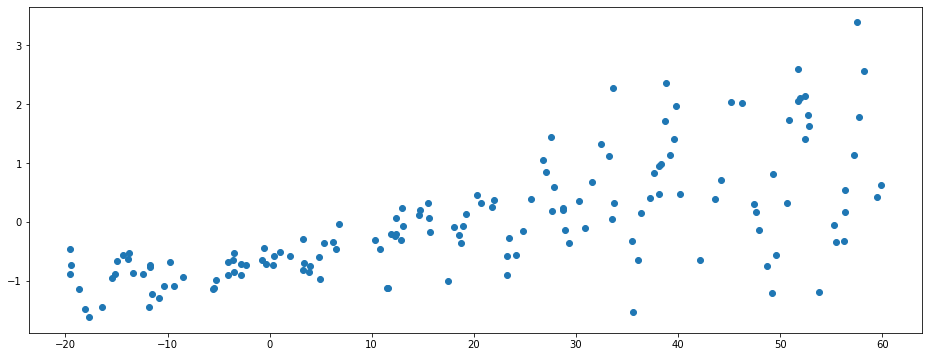

In [2]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

Y, X = load_dataset()

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)

In [3]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)


In [4]:
class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()
        

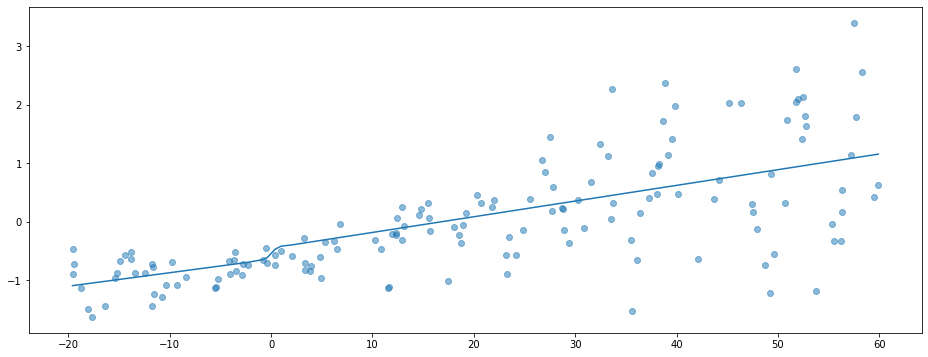

In [5]:
with torch.no_grad():
    plt.figure(figsize=(16, 6))
    plt.plot(X, m(X))
    plt.scatter(X, Y, alpha=0.5)

In [6]:
with torch.no_grad():
    print(torch.abs(m(X) - Y).mean())

tensor(0.5151)


$$ \text{ELBO}  = E_{\theta \sim Q}[\log P(D|\theta)] + D_{KL}(Q(\theta)||P(\theta)) $$

$$ \text{ELBO}  = E_{\theta \sim Q}[\log P(D|\theta)] + \int Q(\theta) \log \frac{P(\theta)}{Q(\theta)}d\theta $$

In [7]:
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [8]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        
    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
    
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [9]:
def elbo(y_pred, y, mu, log_var):
    sigma = log_var.exp()**0.5
    # likelihood of observing y given Variational mu and sigma
    likelihood = dist.Normal(mu, sigma).log_prob(y)
    
    # prior probability of y_pred
    log_prior = dist.Normal(0, 1).log_prob(y_pred)
    
    # variational probability of y_pred
    log_p_q = dist.Normal(mu, sigma).log_prob(y_pred) 
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

    
    

In [10]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

In [11]:
with torch.no_grad():
    print(torch.abs(m(X)[1] - Y).mean())

tensor(0.5138)


In [12]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

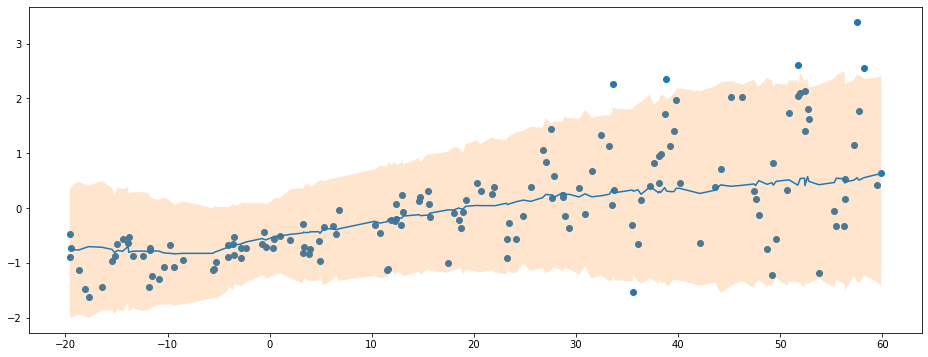

In [13]:
plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

In [14]:
def det_loss(y, y_pred, mu, log_var):    
    reconstruction_error = (0.5 * (y - y_pred)**2).sum()
    kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))

    return reconstruction_error + kl_divergence

$ Q(w) = \mathcal{N}(\mu_{\theta}, \sigma^2_{\theta}) $ 

In [33]:
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, in_features, out_features, parent, n_batches, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.parent = parent
        self.n_batches = n_batches
        
        if getattr(parent, 'accumulated_kl_div', None) is None:
            parent.accumulated_kl_div = 0
            
        # Initialize the variational parameters.
        # 𝑄(𝑤)=N(𝜇_𝜃,𝜎2_𝜃)
        # Do some random initialization with 𝜎=0.01
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            # proxy for variance
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, prior_sd=1):
        log_prior = dist.Normal(0, prior_sd).log_prob(z) 
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        return (log_p_q - log_prior).sum() / self.n_batches
                    

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.parent.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p, 
                                                             )
        if self.include_bias:
            self.parent.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 )
        return z
            


In [34]:
@dataclass
class KL:
    accumulated_kl_div = 0

class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, n_batches)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
        return self.layers(x)
    
m = Model(1, 20, 1, 1)
m(X)[:10]

tensor([[0.2807],
        [0.2807],
        [0.2828],
        [0.2903],
        [0.2968],
        [0.3007],
        [0.3134],
        [0.3250],
        [0.3283],
        [0.3316]], grad_fn=<SliceBackward>)

In [417]:
m.accumulated_kl_div

tensor(908.0202, grad_fn=<AddBackward0>)

In [36]:
epochs = 2000

def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = -dist.Normal(y_pred, .1).log_prob(y).sum() 
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return (reconstruction_error + kl) 
    
m = Model(1, 20, 1, n_batches=1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()
    
    if epoch % 250 == 0:
        print(loss.data.item())

912758.8125
5630.6767578125
4918.69482421875
4853.455078125
4451.697265625
4369.171875
4522.48388671875
4442.5087890625


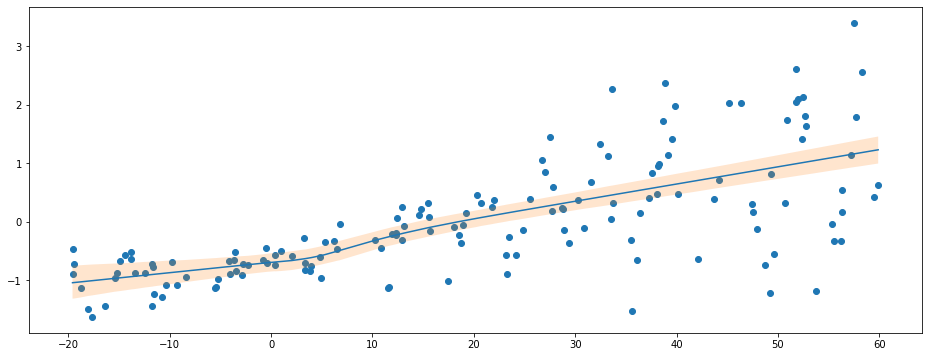

In [37]:
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T
q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)
